# Bagging for data valuation

This notebook introduces the Data-OOB method, from Kwon and Zou "[Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value](https://proceedings.mlr.press/v202/kwon23e.html)" (ICML 2023), using pyDVL.

The objective of this paper is mainly to overcome the computational bottleneck of Shapley-based data valuation methods that require fitting a significant number of models to accurately estimate marginal contributions.
Instead, Data-OOB computes data values from out-of-bag (OOB) error estimates of a bagging model. Originally, the method is therefore only designed for bagging models, but it can be adapted to other models as well.

For a bagging model with $B$ estimators $\hat{f}_b, b \in [B]$, we define $w_{bj}$ as the number of times that the $j$-th sample is in the training set of the $b$-th estimator. For a **fixed** choice of bootstrapped training sets, the Data-OOB value of sample $(x_i, y_i)$ is defined as:
 
$$
\psi(x_i,y_i) := \frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1} (w_{bi}=0)}.
$$

It can therefore be interpreted as a per-sample partition of the standard OOB error estimate for a bagging model, which is: $\frac{1}{n} \sum_{i=1}^n \psi(x_i,y_i)$.

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

import os
import random
from typing import Literal

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from support.common import load_adult_data
from tqdm.notebook import tqdm

from pydvl.reporting.plots import plot_ci_array, plot_ci_values
from pydvl.reporting.scores import compute_removal_score

matplotlib.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

is_CI = os.environ.get("CI")
random_state = 24
random.seed(random_state);

In [2]:
%autoreload
from pydvl.utils import Seed, ensure_seed_sequence
from pydvl.valuation import (
    DataOOBValuation,
    Dataset,
    KNNClassifierUtility,
    ValuationResult,
)

We will work with the [adult classification dataset](https://archive.ics.uci.edu/dataset/2/adult) from the UCI repository. The objective is to predict whether a person earns more than 50k a year based on a set of features such as age, education, occupation, etc.

With a helper function we download the data and obtain the following pandas dataframe, where the categorical features have been removed:

In [3]:
data_adult = load_adult_data()
data_adult = data_adult.sample(frac=0.8, random_state=random_state)

Found cached file: adult_data.pkl.


In [4]:
if is_CI:
    data_adult = data_adult.sample(100, random_state=random_state)

In [5]:
data_adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
1084,31,232475,10,0,0,40,<=50K
1410,48,329778,9,0,0,40,<=50K
1930,43,166740,10,0,0,48,<=50K
1270,47,200734,13,0,0,45,<=50K
1280,52,186785,9,0,1876,50,<=50K


## Computing the OOB values

The main idea of Data-OOB is to use the out-of-bag error estimates of a bagging model to compute data values. In pyDVL, we provide a class [DataOOBValuation][pydvl.valuation.DataOOBValuation] that allows extending this idea to any classifier. The class is designed to take an existing classifier or regression model and compute a per-sample out-of-bag performance estimate via bagging.

For this example, we use a simple KNN classifier with $k=5$ neighbours on the data and compute the data-oob values with two choices for the number of estimators in the bagging.

We then use the [fit][pydvl.valuation.DataOOBValuation.fit] method to compute the values and store them in a [ValuationResult][pydvl.value.result.ValuationResult] object.

In [6]:
data = Dataset(
    data_adult.drop(columns=["income"]).values,
    data_adult.loc[:, "income"].cat.codes.values,
)
model = KNeighborsClassifier(n_neighbors=5)

In [7]:
n_estimators = [100, 500]
oob_values = []
for n_est in n_estimators:
    # model = RandomForestClassifier(n_estimators=n_est,
    #                                max_samples=0.95,
    #                                random_state=random_state)
    # model.fit(data.x, data.y)
    valuation = DataOOBValuation(
        model, n_estimators=n_est, max_samples=0.95, seed=random_state
    )
    valuation.fit(data)
    oob_values.append(valuation.values())

The two results are stored in an array of [ValuationResult][pydvl.value.result.ValuationResult] objects. Here's their distribution. The left-hand side depicts value as it increases with rank and a 99% t-confidence interval. The right-hand side shows the histogram of values.

Observe how adding estimators reduces the variance of the values, but doesn't change their distribution much. 

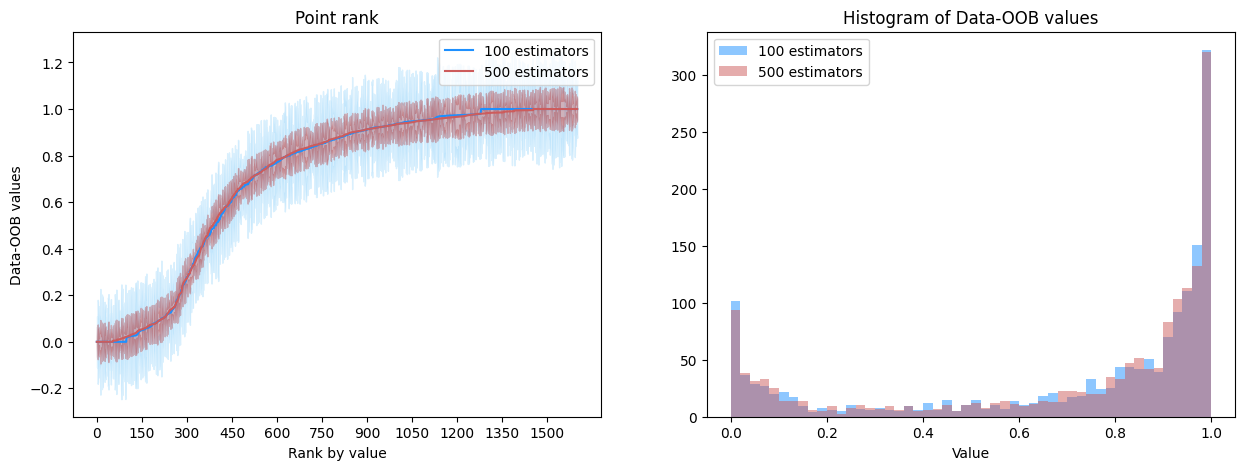

In [8]:
mean_colors = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
shade_colors = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for n_est, values, mean_color, shade_color in zip(
    n_estimators, oob_values, mean_colors, shade_colors
):
    values.sort(key="value")
    plot_ci_values(
        values,
        level=0.01,
        mean_color=mean_color,
        shade_color=shade_color,
        ax=ax1,
        label=f"{n_est} estimators",
    )

    ax2.hist(values, bins=50, color=mean_color, alpha=0.5, label=f"{n_est} estimators")
ax1.set_title("Point rank")
ax1.set_xlabel("Value")
ax1.set_ylabel("Data-OOB values")
ax1.set_xticks(ax1.get_xticks()[::150])
ax1.legend()
ax2.set_title("Histogram of Data-OOB values")
ax2.legend()
plt.plot();

<AxesSubplot: >

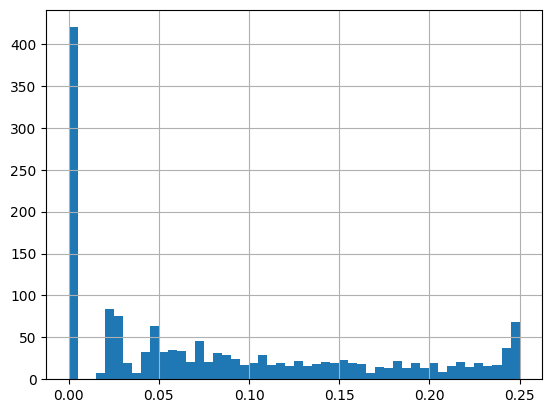

In [10]:
obv, rv = oob_values
df = obv.to_dataframe("oob")
df.to_csv("/tmp/data_oob_values.csv")
df["oob_variances"].hist(bins=50)

In [10]:
def removal_job(
    method: Literal["random", "data_oob"],
    seed: Seed,
    n_est: int = 500,
    max_samples: float = 0.95,
):
    """This is not very efficient, but it's just an example."""
    data = Dataset(
        data_adult.drop(columns=["income"]).values,
        data_adult.loc[:, "income"].cat.codes.values,
    )
    model = KNeighborsClassifier(n_neighbors=5)

    if method == "random":
        values = ValuationResult.from_random(size=len(data), seed=seed)
    else:
        valuation = DataOOBValuation(
            model, n_estimators=n_est, max_samples=max_samples, seed=seed
        )
        valuation.fit(data)
        values = valuation.values()

    best_scores = compute_removal_score(
        KNNClassifierUtility(model, data),
        values,
        data,
        percentages=removal_percentages,
        remove_best=True,
    )
    best_scores["method_name"] = method

    worst_scores = compute_removal_score(
        KNNClassifierUtility(model, data),
        values,
        data,
        percentages=removal_percentages,
        remove_best=False,
    )
    worst_scores["method_name"] = method

    return best_scores, worst_scores

In [11]:
from joblib import Parallel, delayed, parallel_config

n_runs = 20
n_jobs = 20
n_est = 500
max_samples = 0.95
seed = random_state

all_best_scores = []
all_worst_scores = []
removal_percentages = np.arange(0, 0.99, 0.01)

pending = set()

with parallel_config(n_jobs=n_jobs):
    seed_seq = ensure_seed_sequence(seed)
    job = delayed(removal_job)
    args = zip(
        ["random", "data_oob"] * n_runs,
        seed_seq.spawn(2 * n_runs),
        [n_est] * 2 * n_runs,
        [max_samples] * 2 * n_runs,
    )
    with Parallel(return_as="generator_unordered") as parallel:
        delayed_evals = parallel(
            job(method=m, seed=s, n_est=n, max_samples=ms) for m, s, n, ms in args
        )
        for result in tqdm(delayed_evals, unit="%", total=2 * n_runs):
            best_scores, worst_scores = result
            all_best_scores.append(best_scores)
            all_worst_scores.append(worst_scores)

best_scores_df = pd.DataFrame(all_best_scores)
worst_scores_df = pd.DataFrame(all_worst_scores)

  0%|          | 0/40 [00:00<?, ?%/s]

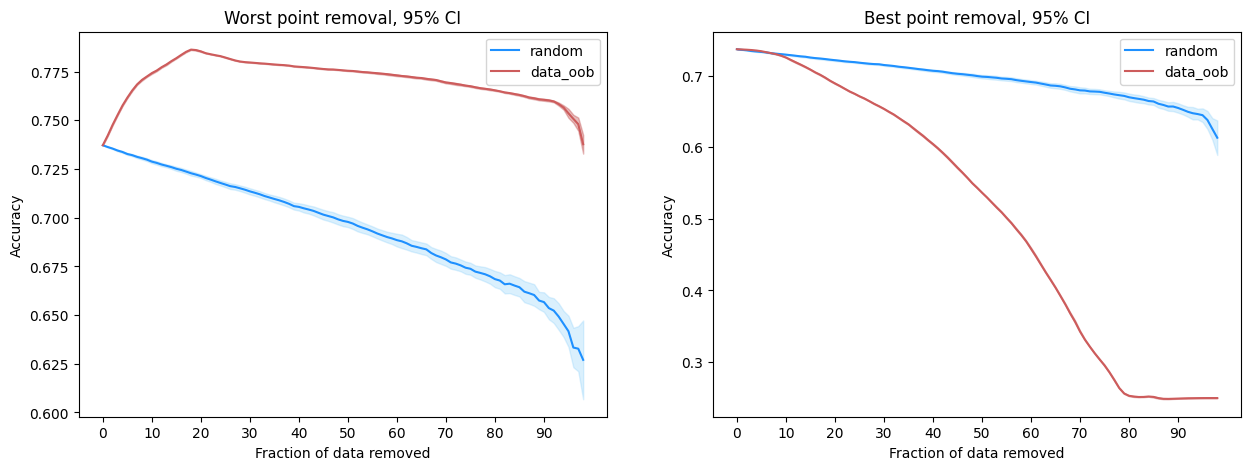

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for i, method_name in enumerate(["random", "data_oob"]):
    plot_ci_array(
        data=worst_scores_df[worst_scores_df["method_name"] == method_name]
        .drop(columns=["method_name"])
        .values,
        level=0.05,
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        label=method_name,
        ax=ax1,
    )
    plot_ci_array(
        best_scores_df[best_scores_df["method_name"] == method_name]
        .drop(columns=["method_name"])
        .values,
        level=0.05,
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        label=method_name,
        ax=ax2,
    )
metric_name = "Accuracy"
ax1.set_title("Worst point removal, 95% CI")
ax1.set_xlabel("Fraction of data removed")
ax1.set_ylabel(metric_name)
ax1.set_xticks(ax1.get_xticks()[::10])
ax1.legend()
ax2.set_title("Best point removal, 95% CI")
ax2.set_xlabel("Fraction of data removed")
ax2.set_xticks(ax2.get_xticks()[::10])
ax2.set_ylabel(metric_name)
ax2.legend()

plt.show();